In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import roberts, prewitt

In [ ]:
# Specify the path to the input fingerprint image
image_path = "/content/Fingerprints.png"

# Read the image in grayscale mode using OpenCV
# cv2.IMREAD_GRAYSCALE ensures the image is loaded as a single channel (black and white)
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)


In [ ]:
# Preprocessing: Noise reduction
image = cv2.GaussianBlur(image, (5, 5), 0)

In [ ]:
# Normalize the pixel values of the grayscale image to the range [0, 1]
# This is done by dividing each pixel value (0 to 255) by 255.0
normalized_image = image / 255.0


In [ ]:
# Apply the Roberts edge detection filter to the normalized image
# The Roberts operator detects edges by calculating the gradient diagonally in the image.
roberts_edges = roberts(normalized_image)

In [ ]:
# Apply Sobel filter to detect edges in both horizontal (x) and vertical (y) directions,
# and compute the magnitude of gradients to highlight edges in the image.
sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)

sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)

sobel_edges = cv2.magnitude(sobel_x, sobel_y)

In [ ]:
# Apply the Prewitt filter to the normalized image for edge detection
# The Prewitt operator calculates gradients in both horizontal and vertical directions
# to identify edges, similar to Sobel but simpler in its computation.
prewitt_edges = prewitt(normalized_image)

In [ ]:
# Apply the Canny edge detection algorithm to the grayscale image
# Input grayscale image, threshold1: Lower threshold for edge linking, threshold2: Upper threshold for edge linking.
canny_edges = cv2.Canny(image, threshold1=50, threshold2=150)

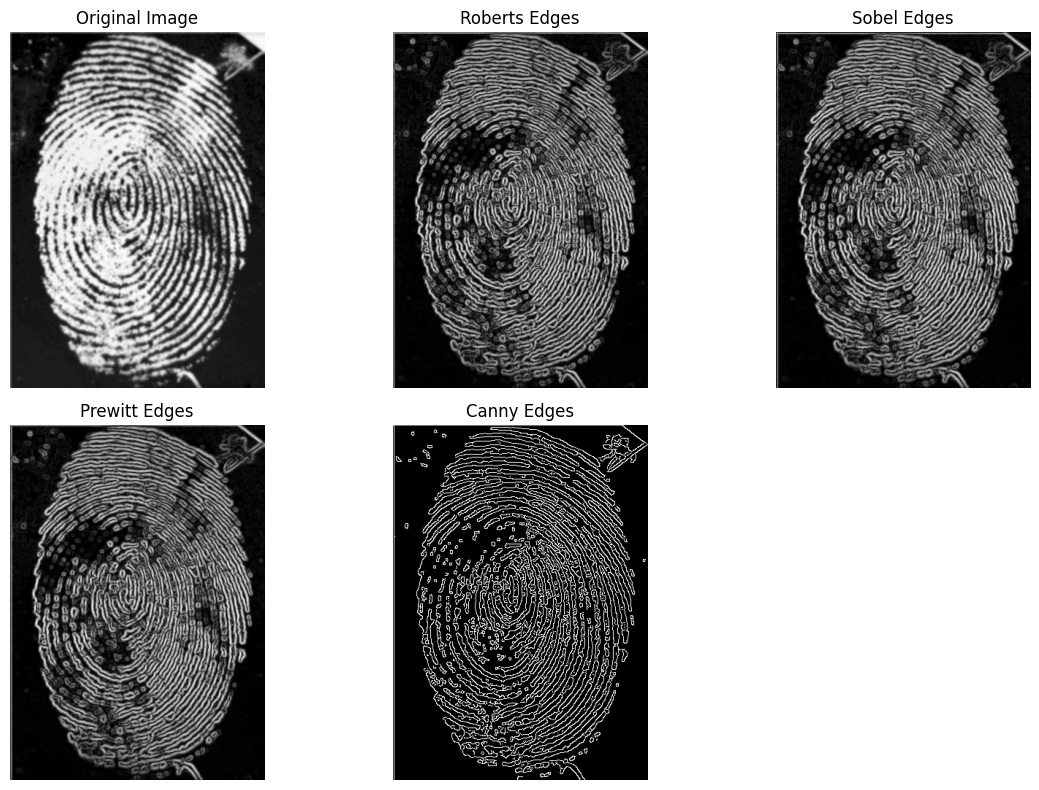

In [ ]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 3, 1)
plt.title('Original Image')
plt.imshow(image, cmap='gray')
plt.axis('off')

plt.subplot(2, 3, 2)
plt.title('Roberts Edges')
plt.imshow(roberts_edges, cmap='gray')
plt.axis('off')

plt.subplot(2, 3, 3)
plt.title('Sobel Edges')
plt.imshow(sobel_edges, cmap='gray')
plt.axis('off')

plt.subplot(2, 3, 4)
plt.title('Prewitt Edges')
plt.imshow(prewitt_edges, cmap='gray')
plt.axis('off')

plt.subplot(2, 3, 5)
plt.title('Canny Edges')
plt.imshow(canny_edges, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
from skimage.metrics import structural_similarity as ssim
import numpy as np
import cv2


def compute_ssim(edges1, edges2):
    """
    Compute the Structural Similarity Index (SSIM) between two edge-detected images.
    Parameters:
    - edges1: First edge-detected image (grayscale).
    - edges2: Second edge-detected image (grayscale).

    Returns:
    - similarity: SSIM value indicating similarity (1 means identical, lower values mean less similar).
    """
    similarity, _ = ssim(edges1, edges2, full=True, data_range=1.0)
    return similarity


def compute_hamming_distance(edges1, edges2):
    """
    Compute the Hamming distance between two binary edge-detected images.
    Parameters:
    - edges1: First edge-detected image.
    - edges2: Second edge-detected image.

    Returns:
    - Normalized Hamming distance (number of differing pixels divided by total pixels).
    """
    edges1_binary = (edges1 > 0).astype(np.uint8)
    edges2_binary = (edges2 > 0).astype(np.uint8)
    xor = np.bitwise_xor(edges1_binary.flatten(), edges2_binary.flatten())
    return np.sum(xor) / xor.size


def compute_correlation(edges1, edges2):
    """
    Compute the Pearson correlation coefficient between two edge-detected images.
    Parameters:
    - edges1: First edge-detected image.
    - edges2: Second edge-detected image.

    Returns:
    - Correlation coefficient (1 means perfect correlation, -1 means perfect inverse correlation).
    """
    edges1_flat = edges1.flatten().astype(np.float32)  # Flatten edges1 into a 1D array
    edges2_flat = edges2.flatten().astype(np.float32)  # Flatten edges2 into a 1D array
    correlation_matrix = np.corrcoef(edges1_flat, edges2_flat)  # Compute the correlation matrix
    return correlation_matrix[0, 1]  # Return the correlation coefficient

# Custom Metric Calculation
def compute_custom_metric(edges1, edges2):
    """
    Compute a custom similarity metric based on overlap between edge pixels.
    Parameters:
    - edges1: First edge-detected image.
    - edges2: Second edge-detected image.

    Returns:
    - Overlap ratio (number of overlapping edge pixels divided by the maximum number of edge pixels in either image).
    """
    overlap = np.sum((edges1 > 0) & (edges2 > 0))
    total_pixels = np.maximum(np.sum(edges1 > 0), np.sum(edges2 > 0))
    return overlap / total_pixels if total_pixels > 0 else 0


In [ ]:
def compare_edges(edges_dict1, edges_dict2):
    """
    Compare edge-detected images using multiple similarity metrics (SSIM, Hamming distance, correlation, and custom metric).

    Parameters:
    - edges_dict1: Dictionary containing edge-detected images (method -> edge image) for the first fingerprint.
    - edges_dict2: Dictionary containing edge-detected images (method -> edge image) for the second fingerprint.

    Returns:
    - results: A dictionary with comparison results for each method (method -> similarity metrics).
    """
    results = {}

    for method in edges_dict1.keys():
        edges1 = edges_dict1[method]
        edges2 = cv2.resize(edges_dict2[method], edges1.shape[::-1])

        results[method] = {
            "SSIM": compute_ssim(edges1, edges2),
            "Hamming Similarity": 1 - compute_hamming_distance(edges1, edges2),
            "Correlation": compute_correlation(edges1, edges2),
            "Custom Metric": compute_custom_metric(edges1, edges2)
        }

    return results


In [ ]:
def preprocess_fingerprint(image_path):
    """
    Preprocess a fingerprint image to generate edges using multiple edge detection methods.

    Parameters:
    - image_path: The path to the fingerprint image to be processed.

    Returns:
    - A dictionary with edge-detected images for various methods (Canny, Roberts, Sobel, Prewitt).
    """
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    normalized_image = image / 255.0

    return {
        "Canny": cv2.Canny(image, 50, 150),
        "Roberts": roberts(normalized_image),
        "Sobel": cv2.magnitude(
            cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3),
            cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
        ),
        "Prewitt": prewitt(normalized_image)
    }

image1_path = "/content/Fingerprints.png"
image2_path = "/content/Fingerprints1.png"

edges1 = preprocess_fingerprint(image1_path)
edges2 = preprocess_fingerprint(image2_path)


Similarity Results and Match Decision:
Method: Canny
  SSIM: 0.1309
  Hamming Similarity: 0.4878
  Correlation: 0.0791
  Custom Metric: 0.2286
  Decision: No Match
----------------------------------------
Method: Roberts
  SSIM: 0.0888
  Hamming Similarity: 0.8027
  Correlation: 0.2077
  Custom Metric: 0.8737
  Decision: No Match
----------------------------------------
Method: Sobel
  SSIM: 0.0051
  Hamming Similarity: 0.8201
  Correlation: 0.2874
  Custom Metric: 0.8634
  Decision: No Match
----------------------------------------
Method: Prewitt
  SSIM: 0.0968
  Hamming Similarity: 0.8975
  Correlation: 0.2563
  Custom Metric: 0.8975
  Decision: No Match
----------------------------------------


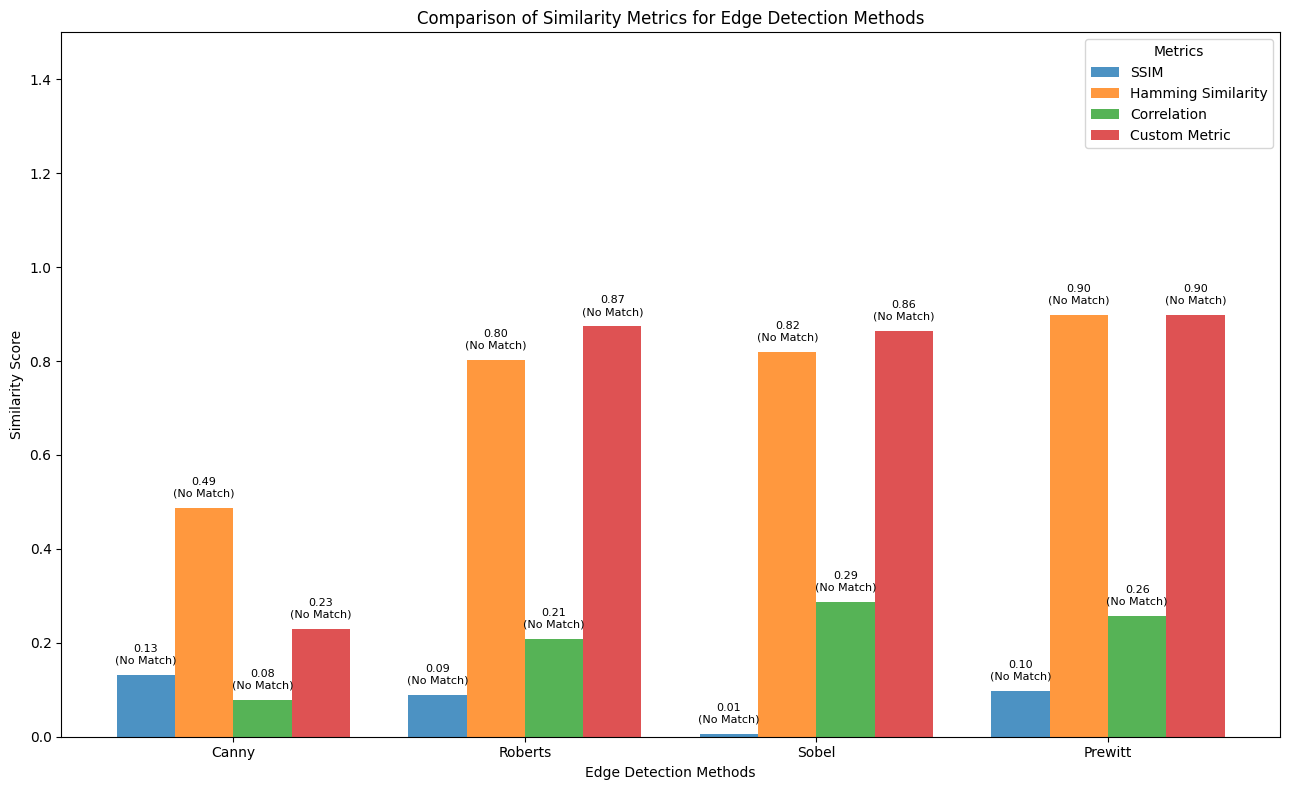

In [ ]:
# Compute similarity results for the two fingerprint images using different edge detection methods
results = compare_edges(edges1, edges2)

# Print similarity results and match decision for each method
print("Similarity Results and Match Decision:")
for method, metrics in results.items():
    ssim_score = metrics["SSIM"]
    custom_metric = metrics["Custom Metric"]

    match_decision = "Match" if ssim_score > 0.8 and custom_metric > 0.7 else "No Match"

    print(f"Method: {method}")
    print(f"  SSIM: {ssim_score:.4f}")
    print(f"  Hamming Similarity: {metrics['Hamming Similarity']:.4f}")
    print(f"  Correlation: {metrics['Correlation']:.4f}")
    print(f"  Custom Metric: {custom_metric:.4f}")
    print(f"  Decision: {match_decision}")
    print("-" * 40)

# Plot the similarity results
import matplotlib.pyplot as plt
import numpy as np

# List of edge detection methods and similarity metrics to plot
methods = list(edges1.keys())
metrics = ["SSIM", "Hamming Similarity", "Correlation", "Custom Metric"]

# Bar chart parameters
bar_width = 0.2
x = np.arange(len(methods))

plt.figure(figsize=(13, 8))

# Plot each metric as a group of bars
for i, metric in enumerate(metrics):
    values = [results[method][metric] for method in methods]
    plt.bar(x + i * bar_width, values, width=bar_width, label=metric, alpha=0.8)

    for j, v in enumerate(values):
        match_decision = "Match" if results[methods[j]]["SSIM"] > 0.8 and results[methods[j]]["Custom Metric"] > 0.7 else "No Match"
        plt.text(j + i * bar_width, v + 0.02, f"{v:.2f}\n({match_decision})", ha='center', va='bottom', fontsize=8)

# Add labels, title, and legend to the plot
plt.title("Comparison of Similarity Metrics for Edge Detection Methods")
plt.xlabel("Edge Detection Methods")
plt.ylabel("Similarity Score")
plt.xticks(x + bar_width * (len(metrics) - 1) / 2, methods)
plt.ylim(0, 1.5)
plt.legend(title="Metrics")
plt.tight_layout()

# Display the plot
plt.show()

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import roberts, prewitt
from skimage.morphology import skeletonize
import time
import os

# Specify the input image path and output directory
image_path = "/content/Fingerprints.png"  # Path to the single fingerprint image
output_dir = "/content/fingerprint_results/"  # Directory to save results

# Create output directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Read the image in grayscale mode
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
if image is None:
    print(f"Failed to load image: {image_path}")
    exit()

# --- Preprocessing ---
# Apply CLAHE (Contrast Limited Adaptive Histogram Equalization) for contrast enhancement
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
enhanced_image = clahe.apply(image)

# Apply Gaussian blur to reduce noise
blurred_image = cv2.GaussianBlur(enhanced_image, (5, 5), 0)

# Binarize the image using adaptive thresholding
binary_image = cv2.adaptiveThreshold(
    blurred_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2
)

# Normalize the pixel values of the grayscale image to [0, 1] for Roberts and Prewitt
normalized_image = enhanced_image / 255.0

# --- Edge Detection with Timing ---
edge_times = {}

# Roberts Edge Detection
start_time = time.time()
roberts_edges = roberts(normalized_image)
edge_times['Roberts'] = time.time() - start_time

# Sobel Edge Detection
start_time = time.time()
sobel_x = cv2.Sobel(blurred_image, cv2.CV_64F, 1, 0, ksize=3)
sobel_y = cv2.Sobel(blurred_image, cv2.CV_64F, 0, 1, ksize=3)
sobel_edges = cv2.magnitude(sobel_x, sobel_y)
edge_times['Sobel'] = time.time() - start_time

# Prewitt Edge Detection
start_time = time.time()
prewitt_edges = prewitt(normalized_image)
edge_times['Prewitt'] = time.time() - start_time

# Canny Edge Detection
start_time = time.time()
canny_edges = cv2.Canny(blurred_image, threshold1=50, threshold2=150)
edge_times['Canny'] = time.time() - start_time

# --- Minutiae Detection ---
# Skeletonize the binary image
skeleton = skeletonize(binary_image / 255.0)

# Function to detect minutiae (endings and bifurcations)
def detect_minutiae(skeleton):
    minutiae = []
    rows, cols = skeleton.shape
    for i in range(1, rows-1):
        for j in range(1, cols-1):
            if skeleton[i, j] == 1:
                neighbors = skeleton[i-1:i+2, j-1:j+2].flatten()
                neighbor_count = np.sum(neighbors) - 1  # Exclude center pixel
                if neighbor_count == 1:  # Ridge ending
                    minutiae.append((j, i, 'ending'))
                elif neighbor_count == 3:  # Bifurcation
                    minutiae.append((j, i, 'bifurcation'))
    return minutiae

# Detect minutiae
minutiae_points = detect_minutiae(skeleton)
minutiae_count = len(minutiae_points)

# --- Edge Continuity Score ---
# Simple metric: Count the number of connected edge pixels (non-zero) in the edge-detected images
def edge_continuity_score(edge_image):
    _, binary_edge = cv2.threshold(edge_image.astype(np.uint8), 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return np.sum(binary_edge > 0)

continuity_scores = {
    'Roberts': edge_continuity_score(roberts_edges * 255),
    'Sobel': edge_continuity_score(sobel_edges),
    'Prewitt': edge_continuity_score(prewitt_edges * 255),
    'Canny': edge_continuity_score(canny_edges)
}

# --- Visualization of Processed Images ---
plt.figure(figsize=(15, 10))

# Original Image
plt.subplot(2, 4, 1)
plt.title('Original Image')
plt.imshow(image, cmap='gray')
plt.axis('off')

# Enhanced Image (CLAHE)
plt.subplot(2, 4, 2)
plt.title('Enhanced Image (CLAHE)')
plt.imshow(enhanced_image, cmap='gray')
plt.axis('off')

# Binary Image
plt.subplot(2, 4, 3)
plt.title('Binary Image')
plt.imshow(binary_image, cmap='gray')
plt.axis('off')

# Skeletonized Image
plt.subplot(2, 4, 4)
plt.title('Skeletonized Image')
plt.imshow(skeleton, cmap='gray')
plt.axis('off')

# Roberts Edges
plt.subplot(2, 4, 5)
plt.title(f'Roberts Edges\nTime: {edge_times["Roberts"]:.3f}s\nScore: {continuity_scores["Roberts"]}')
plt.imshow(roberts_edges, cmap='gray')
plt.axis('off')

# Sobel Edges
plt.subplot(2, 4, 6)
plt.title(f'Sobel Edges\nTime: {edge_times["Sobel"]:.3f}s\nScore: {continuity_scores["Sobel"]}')
plt.imshow(sobel_edges, cmap='gray')
plt.axis('off')

# Prewitt Edges
plt.subplot(2, 4, 7)
plt.title(f'Prewitt Edges\nTime: {edge_times["Prewitt"]:.3f}s\nScore: {continuity_scores["Prewitt"]}')
plt.imshow(prewitt_edges, cmap='gray')
plt.axis('off')

# Canny Edges
plt.subplot(2, 4, 8)
plt.title(f'Canny Edges\nTime: {edge_times["Canny"]:.3f}s\nScore: {continuity_scores["Canny"]}')
plt.imshow(canny_edges, cmap='gray')
plt.axis('off')

plt.tight_layout()
# Save the figure
output_path = os.path.join(output_dir, "image_edges.png")
plt.savefig(output_path)
plt.close()

# Visualize Minutiae Points
plt.figure(figsize=(8, 8))
plt.imshow(image, cmap='gray')
for x, y, minutiae_type in minutiae_points:
    color = 'red' if minutiae_type == 'ending' else 'blue'
    plt.plot(x, y, 'o', color=color, markersize=5)
plt.title(f'Minutiae Points (Red: Endings, Blue: Bifurcations)\nTotal: {minutiae_count}')
plt.axis('off')
# Save the minutiae figure
minutiae_output_path = os.path.join(output_dir, "image_minutiae.png")
plt.savefig(minutiae_output_path)
plt.close()

# --- Histogram Comparison ---
# Prepare edge images for histogram (normalize to [0, 255] for consistency)
roberts_edges_uint8 = (roberts_edges * 255).astype(np.uint8)
prewitt_edges_uint8 = (prewitt_edges * 255).astype(np.uint8)
sobel_edges_uint8 = cv2.normalize(sobel_edges, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

# Histogram for Pixel Intensities
plt.figure(figsize=(12, 8))
plt.hist(image.ravel(), bins=50, alpha=0.5, label='Original', color='gray', edgecolor='black')
plt.hist(roberts_edges_uint8.ravel(), bins=50, alpha=0.5, label='Roberts', color='blue', edgecolor='black')
plt.hist(sobel_edges_uint8.ravel(), bins=50, alpha=0.5, label='Sobel', color='green', edgecolor='black')
plt.hist(prewitt_edges_uint8.ravel(), bins=50, alpha=0.5, label='Prewitt', color='red', edgecolor='black')
plt.hist(canny_edges.ravel(), bins=50, alpha=0.5, label='Canny', color='purple', edgecolor='black')
plt.title('Histogram of Pixel Intensities')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig(os.path.join(output_dir, "histogram_intensities.png"))
plt.close()

# Print performance metrics
print("Edge Detection Performance:")
for method, runtime in edge_times.items():
    print(f"{method}: {runtime:.3f} seconds, Continuity Score: {continuity_scores[method]}")
print(f"Minutiae Count: {minutiae_count}")

# Save summary to a text file
with open(os.path.join(output_dir, "summary.txt"), "w") as f:
    f.write("Edge Detection Performance:\n")
    for method, runtime in edge_times.items():
        f.write(f"{method}: {runtime:.3f} seconds, Continuity Score: {continuity_scores[method]}\n")
    f.write(f"Minutiae Count: {minutiae_count}\n")

Edge Detection Performance:
Roberts: 0.005 seconds, Continuity Score: 51075
Sobel: 0.002 seconds, Continuity Score: 64253
Prewitt: 0.007 seconds, Continuity Score: 56139
Canny: 0.003 seconds, Continuity Score: 29288
Minutiae Count: 3577


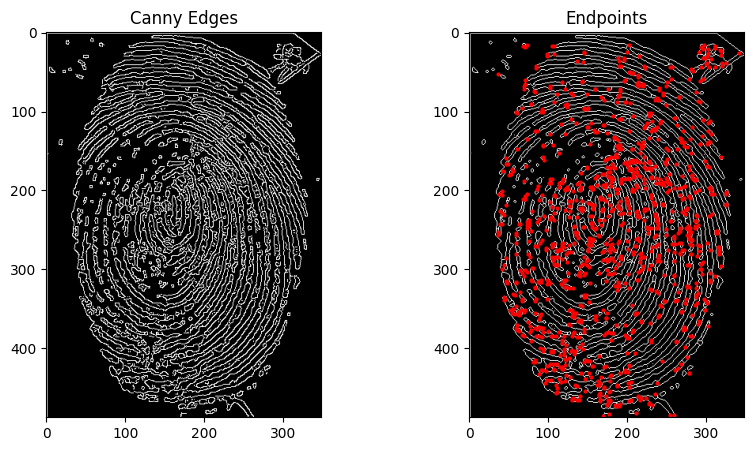

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import roberts, prewitt
from skimage.morphology import skeletonize

# Load and preprocess image
image = cv2.imread("/content/Fingerprints.png", cv2.IMREAD_GRAYSCALE)
image = cv2.GaussianBlur(image, (5, 5), 0)
normalized_image = image / 255.0

# Edge detection (Canny as example)
canny_edges = cv2.Canny(image, 50, 150)

# Skeletonize edges for minutiae detection
skeleton = skeletonize(canny_edges / 255).astype(np.uint8) * 255

# Basic minutiae detection (endpoints)
endpoints = []
for i in range(1, skeleton.shape[0] - 1):
    for j in range(1, skeleton.shape[1] - 1):
        if skeleton[i, j] == 255:
            neighbors = np.sum(skeleton[i-1:i+2, j-1:j+2]) // 255
            if neighbors == 2:  # Endpoint (1 neighbor + itself)
                endpoints.append((j, i))

# Visualize
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1), plt.title('Canny Edges'), plt.imshow(canny_edges, cmap='gray')
plt.subplot(1, 2, 2), plt.title('Endpoints'), plt.imshow(skeleton, cmap='gray')
for x, y in endpoints:
    plt.plot(x, y, 'ro', markersize=2)
plt.show()

Match Percentage: 100.00%
Pictures have been matched, SAME PICTURES


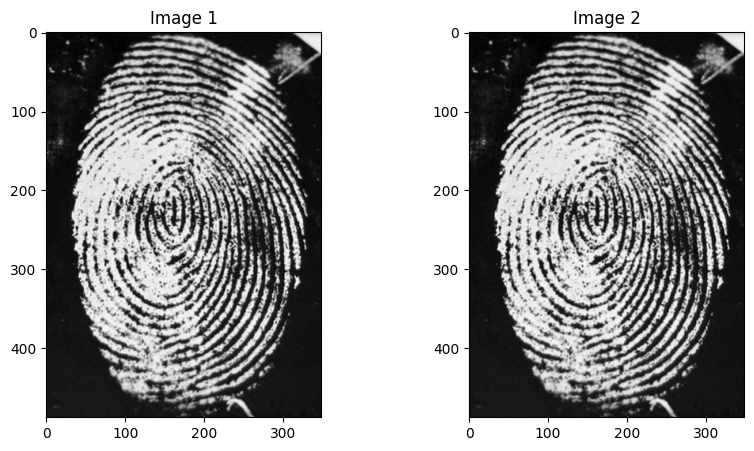

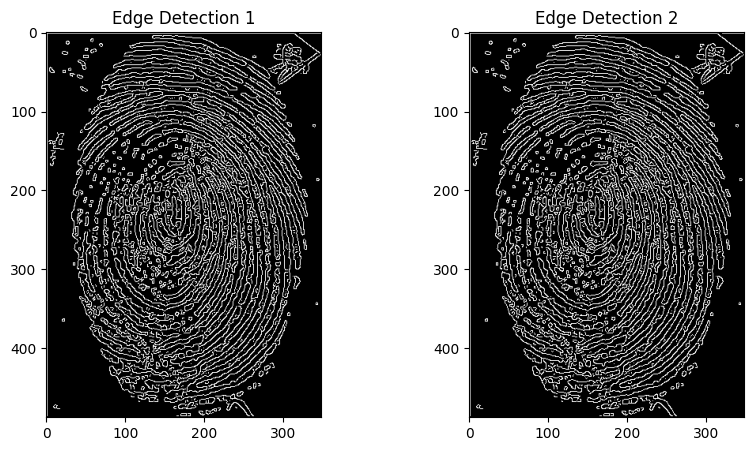

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from skimage.feature import canny

# Clear all previous figures
plt.close('all')

# Read images
pic1 = io.imread('/content/Fingerprints.png', as_gray=True)
pic2 = io.imread('/content/Fingerprints.png', as_gray=True)  # SAME image
# pic2 = io.imread('C:/Users/Bhoomika/Desktop/2.jpg', as_gray=True)  # DIFFERENT image

# Display original images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(pic1, cmap='gray')
plt.title('Image 1')
plt.subplot(1, 2, 2)
plt.imshow(pic2, cmap='gray')
plt.title('Image 2')

# Edge detection (using Canny instead of Prewitt as it's more common in Python)
edge_det_pic1 = canny(pic1)
edge_det_pic2 = canny(pic2)

# Display edge-detected images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(edge_det_pic1, cmap='gray')
plt.title('Edge Detection 1')
plt.subplot(1, 2, 2)
plt.imshow(edge_det_pic2, cmap='gray')
plt.title('Edge Detection 2')

# Output messages
OUTPUT_MESSAGE = 'Pictures have been matched, SAME PICTURES'
OUTPUT_MESSAGE2 = 'Pictures have not been matched, DIFFERENT PICTURES'

# Initialize variables
matched_data = 0
white_points = 0
black_points = 0

# Get the actual shape of the image
image_height, image_width = edge_det_pic1.shape

# Count white and black points in first image
# Using the actual image dimensions
for a in range(image_height):
    for b in range(image_width):
        if edge_det_pic1[a, b]:  # True represents white (edge) points
            white_points += 1
        else:
            black_points += 1

# Compare white (edge) points in both images
# Using the actual image dimensions
for i in range(image_height):
    for j in range(image_width):
        if edge_det_pic1[i, j] and edge_det_pic2[i, j]:
            matched_data += 1

# Calculate percentage matching
total_data = white_points
total_matched_percentage = (matched_data / total_data) * 100

# Output results
print(f"Match Percentage: {total_matched_percentage:.2f}%")
if total_matched_percentage >= 90:
    print(OUTPUT_MESSAGE)
else:
    print(OUTPUT_MESSAGE2)

plt.show()

Match Percentage: 15.12%
Pictures have not been matched, DIFFERENT PICTURES


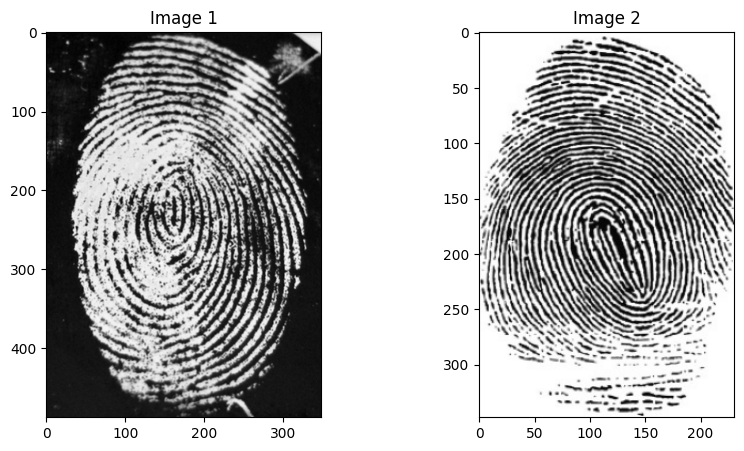

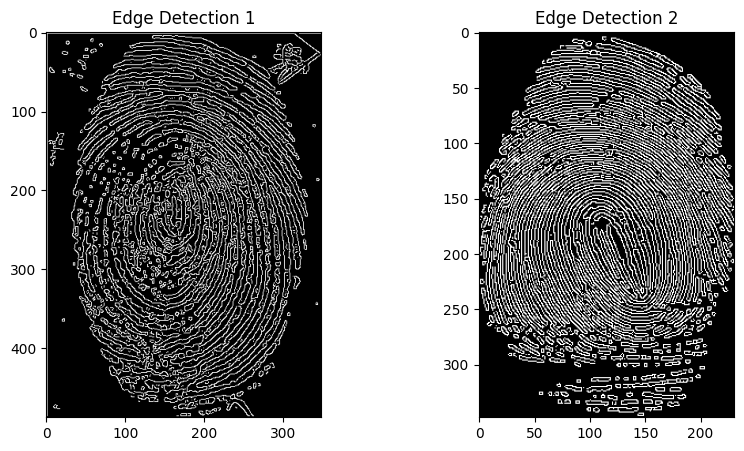

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from skimage.feature import canny

# Clear all previous figures
plt.close('all')

# Read images
pic1 = io.imread('/content/Fingerprints.png', as_gray=True)
pic2 = io.imread('/content/Fingerprints1.png', as_gray=True)  # SAME image
# pic2 = io.imread('C:/Users/Bhoomika/Desktop/2.jpg', as_gray=True)  # DIFFERENT image

# Display original images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(pic1, cmap= 'gray')
plt.title('Image 1')
plt.subplot(1, 2, 2)
plt.imshow(pic2, cmap='gray')
plt.title('Image 2')

# Edge detection (using Canny instead of Prewitt as it's more common in Python)
edge_det_pic1 = canny(pic1)
edge_det_pic2 = canny(pic2)

# Display edge-detected images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(edge_det_pic1, cmap='gray')
plt.title('Edge Detection 1')
plt.subplot(1, 2, 2)
plt.imshow(edge_det_pic2, cmap='gray')
plt.title('Edge Detection 2')

# Output messages
OUTPUT_MESSAGE = 'Pictures have been matched, SAME PICTURES'
OUTPUT_MESSAGE2 = 'Pictures have not been matched, DIFFERENT PICTURES'

# Initialize variables
matched_data = 0
white_points = 0
black_points = 0

# Get the minimum shape for both images
min_height = min(edge_det_pic1.shape[0], edge_det_pic2.shape[0])
min_width = min(edge_det_pic1.shape[1], edge_det_pic2.shape[1])

# Count white and black points in first image
# Using the actual image dimensions
for a in range(edge_det_pic1.shape[0]):
    for b in range(edge_det_pic1.shape[1]):
        if edge_det_pic1[a, b]:  # True represents white (edge) points
            white_points += 1
        else:
            black_points += 1

# Compare white (edge) points in both images
# Use the minimum dimensions to prevent index out of bounds error
for i in range(min_height):
    for j in range(min_width):
        if edge_det_pic1[i, j] and edge_det_pic2[i, j]:
            matched_data += 1

# Calculate percentage matching
total_data = white_points
total_matched_percentage = (matched_data / total_data) * 100

# Output results
print(f"Match Percentage: {total_matched_percentage:.2f}%")
if total_matched_percentage >= 90:
    print(OUTPUT_MESSAGE)
else:
    print(OUTPUT_MESSAGE2)

plt.show()

1. Feature Extraction using ORB (Oriented FAST and Rotated BRIEF)

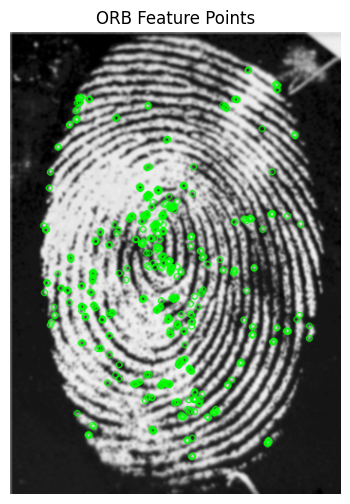

In [ ]:
# Initialize ORB detector
orb = cv2.ORB_create()

# Detect keypoints and compute descriptors
keypoints, descriptors = orb.detectAndCompute(image, None)

# Draw keypoints on the image
image_with_keypoints = cv2.drawKeypoints(image, keypoints, None, color=(0, 255, 0), flags=0)

# Show the result
plt.figure(figsize=(6, 6))
plt.imshow(image_with_keypoints, cmap='gray')
plt.title('ORB Feature Points')
plt.axis('off')
plt.show()


 Matching Two Fingerprints (ORB Descriptors + BFMatcher)

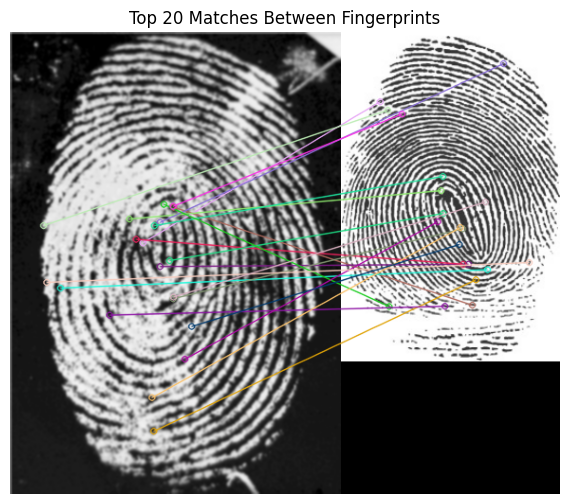

In [ ]:

image2_path = "/content/Fingerprints1.png"
image2 = cv2.imread(image2_path, cv2.IMREAD_GRAYSCALE)

# Detect and compute features in the second image
kp2, des2 = orb.detectAndCompute(image2, None)

# Brute-Force matcher with Hamming distance
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# Match descriptors
matches = bf.match(descriptors, des2)

# Sort matches by distance (best first)
matches = sorted(matches, key=lambda x: x.distance)

# Draw top 20 matches
matched_image = cv2.drawMatches(image, keypoints, image2, kp2, matches[:20], None, flags=2)

# Show matches
plt.figure(figsize=(12, 6))
plt.imshow(matched_image)
plt.title('Top 20 Matches Between Fingerprints')
plt.axis('off')
plt.show()


Minutiae Detection (Basic Ridge End/Bifurcation Detection Idea)

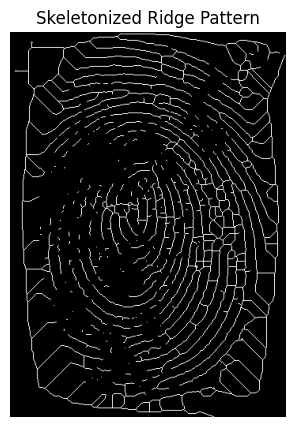

In [ ]:
from skimage.morphology import skeletonize
from skimage.util import invert

# Binarize and invert the image
binary_image = image > 127
skeleton = skeletonize(invert(binary_image))

# Show skeleton
plt.figure(figsize=(5, 5))
plt.imshow(skeleton, cmap='gray')
plt.title('Skeletonized Ridge Pattern')
plt.axis('off')
plt.show()


Summary

## 🔍 Summary of Fingerprint Edge Detection

This project demonstrates edge detection techniques on a fingerprint image using Python libraries like OpenCV and scikit-image. Edge detection is crucial in fingerprint processing as it highlights ridge patterns used for identification and analysis.

### ✅ Filters Applied:
- **Roberts** – Detects edges diagonally, useful for simple changes
- **Sobel** – Captures horizontal and vertical edges; highlights gradients
- **Prewitt** – Similar to Sobel but with a different kernel for gradient estimation
- **Canny** – A multi-stage filter; offers precise and noise-resistant edges

### 🧼 Preprocessing:
- **Gaussian Blur** is used to reduce image noise before applying edge detection filters, improving edge clarity and reducing false edges.

### 📊 Observations:
- Canny performs best in detecting clean and continuous fingerprint ridges.
- Sobel and Prewitt highlight broad edge structures.
- Roberts detects sharper but sometimes noisy edges.

### 💡 Conclusion:
This edge detection pipeline can serve as a starting point for more advanced fingerprint recognition systems.
- Minutiae detection (ridge endings and bifurcations)
- Feature matching between fingerprints
- Ridge thinning and skeletonization

